## Loading data and preliminary analysis

In [6]:
import re
import random
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)

In [7]:
data=pd.read_csv("D:\Downloads\Chatbot-for-mental-health-main\mental_health_dataset.csv",nrows=20)

In [8]:
data.head()

,Question_ID,Questions,Answers
0,1,Affirmations,You are deserving of love and compassion.
1,2,Coping Strategies,Practice mindfulness to stay present in the mo...
2,3,Supportive Messages,You are not alone; there is strength in reachi...
3,4,Self-Care Tips,Take a break when needed; self-care is crucial...
4,5,Positive Reminders,Embrace each day as a new opportunity for grow...


In [9]:
# data preprocessing 

for i in range(data.shape[0]):
  data['Answers'][i]=re.sub(r'\n', ' ',data['Answers'][i])
  data['Answers'][i]=re.sub('\(', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'\)', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r',', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'-', '',data['Answers'][i])
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])  
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])

In [10]:
pairs=[]

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]),data['Answers'][i]))

In [11]:
pairs                                     # questions

[('Affirmations', 'You are deserving of love and compassion.'),
 ('Coping Strategies', 'Practice mindfulness to stay present in the moment.'),
 ('Supportive Messages',
  'You are not alone; there is strength in reaching out for support.'),
 ('Self-Care Tips',
  'Take a break when needed; selfcare is crucial for your wellbeing.'),
 ('Positive Reminders',
  'Embrace each day as a new opportunity for growth and healing.'),
 ('Affirmations',
  'Your journey is unique and you have the power to shape it positively.'),
 ('Coping Strategies',
  'Establish healthy boundaries to protect your mental and emotional space.'),
 ('Supportive Messages',
  "Your feelings are valid and it's okay to express them openly."),
 ('Self-Care Tips',
  'Prioritize rest; a wellrested mind is better equipped to handle challenges.'),
 ('Positive Reminders',
  'Celebrate your progress no matter how small; every step forward counts.'),
 ('Affirmations',
  'You possess the inner strength needed to overcome obstacles.')

## Data preprocessing 

In [12]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'

  target_docs.append(target_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [13]:
input_docs

['Affirmations',
 'Coping Strategies',
 'Supportive Messages',
 'Self-Care Tips',
 'Positive Reminders',
 'Affirmations',
 'Coping Strategies',
 'Supportive Messages',
 'Self-Care Tips',
 'Positive Reminders',
 'Affirmations',
 'Coping Strategies',
 'Supportive Messages',
 'Self-Care Tips',
 'Positive Reminders',
 'Affirmations',
 'Coping Strategies',
 'Supportive Messages',
 'Self-Care Tips',
 'Positive Reminders']

In [14]:
target_docs

['<START> You are deserving of love and compassion . <END>',
 '<START> Practice mindfulness to stay present in the moment . <END>',
 '<START> You are not alone ; there is strength in reaching out for support . <END>',
 '<START> Take a break when needed ; selfcare is crucial for your wellbeing . <END>',
 '<START> Embrace each day as a new opportunity for growth and healing . <END>',
 '<START> Your journey is unique and you have the power to shape it positively . <END>',
 '<START> Establish healthy boundaries to protect your mental and emotional space . <END>',
 "<START> Your feelings are valid and it's okay to express them openly . <END>",
 '<START> Prioritize rest ; a wellrested mind is better equipped to handle challenges . <END>',
 '<START> Celebrate your progress no matter how small ; every step forward counts . <END>',
 '<START> You possess the inner strength needed to overcome obstacles . <END>',
 '<START> Engage in activities you enjoy to bring joy into your life . <END>',
 '<STA

In [15]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [16]:
input_features_dict

{'-': 0,
 'Affirmations': 1,
 'Care': 2,
 'Coping': 3,
 'Messages': 4,
 'Positive': 5,
 'Reminders': 6,
 'Self': 7,
 'Strategies': 8,
 'Supportive': 9,
 'Tips': 10}

## Encoder - Decoder model

In [17]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [18]:
encoder_input_data

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0.,

In [19]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Training

In [20]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model  
dimensionality = 256 # Dimensionality 
batch_size = 10   # The batch size and number of epochs
epochs = 500 

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [22]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 11)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 142)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        274432      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')#Training
history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('training_model.h5')

Epoch 1/500


2/2 [==============================] - 7s 1s/step - loss: 2.7736 - accuracy: 0.1328 - val_loss: 2.7716 - val_accuracy: 0.0938
Epoch 2/500
2/2 [==============================] - 0s 73ms/step - loss: 2.7299 - accuracy: 0.2240 - val_loss: 2.5731 - val_accuracy: 0.4792
Epoch 3/500
2/2 [==============================] - 0s 82ms/step - loss: 2.5338 - accuracy: 0.3438 - val_loss: 2.6112 - val_accuracy: 0.0417
Epoch 4/500
2/2 [==============================] - 0s 104ms/step - loss: 2.4845 - accuracy: 0.1979 - val_loss: 2.6264 - val_accuracy: 0.0417
Epoch 5/500
2/2 [==============================] - 0s 94ms/step - loss: 2.4504 - accuracy: 0.2318 - val_loss: 2.6511 - val_accuracy: 0.0521
Epoch 6/500
2/2 [==============================] - 0s 96ms/step - loss: 2.4399 - accuracy: 0.1484 - val_loss: 2.6532 - val_accuracy: 0.4792
Epoch 7/500
2/2 [==============================] - 0s 98ms/step - loss: 2.4155 - accuracy: 0.3984 - val_loss: 2.6642 - val_accuracy: 0.4792
Epoch 8/500
2/2 [================

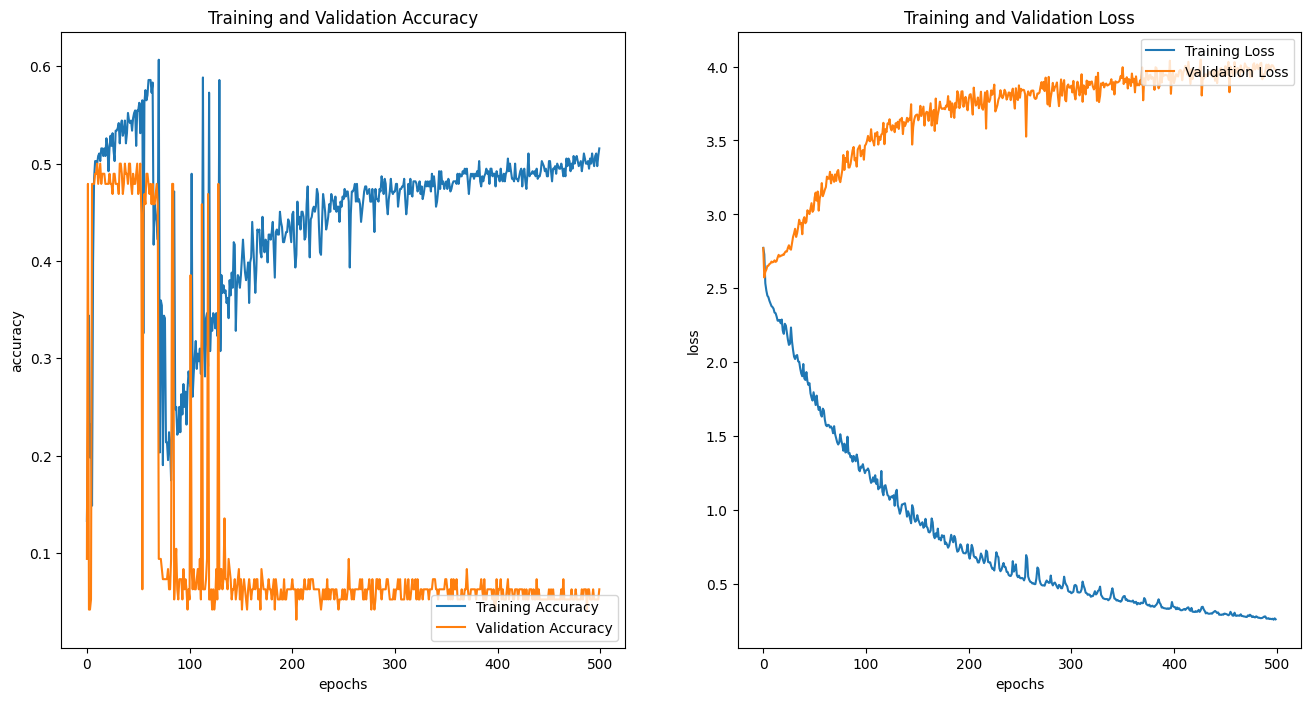

In [25]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [26]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [27]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [28]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [29]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [30]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
          
          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
          
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [31]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

## Demo

In [32]:
chatbot.start_chat()

1/1 [==============================] - 0s 45ms/step
